In [70]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle

Essential to run all this section: load the pickl of our experiment -- make sure to change the path ;) 

You can print level on and level two keys in case you have a doubt (cell 5) one can use these list to loop over the dataset  
- Level 1 will let you chose which method you want to see: raw, or method 1, 2, or 3  (corresponding to each level of challenge)
- Level 2 which of the 6 sequences


In [71]:
def load_dict_of_dicts_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [72]:
data = load_dict_of_dicts_pickle(r"C:\Users\thang\OneDrive\Desktop\school\DataChallenge\data_metrics.pkl")

MemoryError: 

In [ ]:
level_one_keys = list(data.keys())
level_two_keys =[]
for k in level_one_keys:
    level_two_keys.extend(list(data[k].keys()))
level_two_keys = set(level_two_keys)

In [ ]:
print(level_one_keys)
print(level_two_keys)

['method_1', 'method_2', 'method_3', 'raw']
{'scene_1', 'car_scene_3', 'car_scene_1', 'scene_2', 'car_scene_2', 'scene_3'}


In [ ]:

def compartive_metrics_loop_(data, method: str,function, idx:int = 0 ):
    """
    takes the name of a method (string) and a function
    will measure and return a comparative mettric betwenn raw image and filtered image of index idx
    in tha sequence.
    theresults are returned in a list
    if idx is none will compare the two complete sequences
    """

    raw_images = data["raw"]
    method = data[method]

    featured = {}
    if idx is not None:
        for k in level_two_keys:
            raw_pic = raw_images[k][idx]
            cal_pic = method[k][idx]
            featured.update({k:function(raw_pic, cal_pic)})
    else:
        for k in level_two_keys:
            raw_seq = raw_images[k]
            cal_seq = method[k]
            featured.update({k:function(raw_seq, cal_seq)})
    return featured

In [ ]:
def single_metrics_loop_(data, method: str,function, idx:int = 0 ):
    """
    same as the previous one but for non comparative metrics
    """
    method = data[method]

    featured = {}
    if idx is not None:
        for k in level_two_keys:
            pic = method[k][idx]
            featured.update({k:function(pic)})
    else:
        for k in level_two_keys:
            seq = method[k]
            featured.update({k:function(seq)})
    return featured

### Metrics

Store all your metrics in this section

#### Simple metric

In [ ]:
def calculate_metrics(original_image, corrected_image):
    var = np.var(corrected_image)
    mean_pixel_value = np.mean(corrected_image)
    std_deviation = np.std(corrected_image)
    nues = (std_deviation / mean_pixel_value) * 100
    roughness = np.sum(np.abs(np.diff(corrected_image, axis=0))) + np.sum(np.abs(np.diff(corrected_image, axis=1)))
    mse = np.mean((original_image - corrected_image) ** 2)
    max_pixel_value = 2**14 - 1  # 14-bit images
    psnr = 10 * np.log10(max_pixel_value**2 / mse)

    return {
        'Variance': var,
        'NUES': nues,
        'Roughness Index': roughness,
        'PSNR': psnr
    }

In [ ]:
import numpy as np
from scipy.signal import convolve2d

def calculate_roughness_index(image):
    # Define horizontal and vertical masks
    v1 = np.array([[1, -1]])
    v2 = np.array([[1, -1]])
    
    # Perform discrete convolutions
    conv_v1 = convolve2d(image, v1, mode='same', boundary='symm')
    conv_v2 = convolve2d(image, v2, mode='same', boundary='symm')
    
    # Calculate the first-order norms
    norm_conv_v1 = np.sum(np.abs(conv_v1))
    norm_conv_v2 = np.sum(np.abs(conv_v2))
    norm_image = np.sum(np.abs(image))
    
    # Compute the Roughness Index
    roughness_index = (norm_conv_v1 + norm_conv_v2) / norm_image
    
    return roughness_index

# Example usage with a synthetic image (replace with your actual image data)
# image = np.random.rand(100, 100)  # Replace with actual image data
# img1 = corrected_scene_images[350]

# roughness_index = calculate_roughness_index(img1)
# print("Roughness Index:", roughness_index)


#### Count feature

In [ ]:
def count_features(image: np.ndarray) -> int:
    if image is None or image.size == 0:
        return 0
    if len(image.shape) != 2:
        return 0
    
    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    orb = cv2.ORB_create()
    keypoints = orb.detect(image, None)
    return len(keypoints)

def feature_ratio(raw,filtered):
    return count_features(filtered)/count_features(raw)

In [ ]:
from skimage.feature import hog
from skimage import exposure

def count_features_hog(image: np.ndarray) -> int:
    if image is None or image.size == 0:
        return 0
    if len(image.shape) != 2:
        return 0

    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Compute HOG features and HOG image
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys',
                              visualize=True, transform_sqrt=True, feature_vector=True)

    return len(features)

def feature_ratio_hog(raw, filtered):
    return count_features_hog(filtered) / count_features_hog(raw)

#### contrast noise ratio

In [ ]:
def contrast_to_noise_ratio(image, object_mask, background_mask):
    """
    Calculate the Contrast-to-Noise Ratio (CNR) of an image.
    
    Parameters:
    image (torch.Tensor): Input image as a PyTorch tensor.
    object_mask (torch.Tensor): Boolean mask for the object region.
    background_mask (torch.Tensor): Boolean mask for the background region.
    
    Returns:
    float: The CNR value.
    """
    # Ensure the masks are boolean tensors
    object_mask = object_mask.bool()
    background_mask = background_mask.bool()
    
    # Calculate mean intensities
    mu_object = torch.mean(image[object_mask])
    mu_background = torch.mean(image[background_mask])
    
    # Calculate standard deviation of the background
    sigma_background = torch.std(image[background_mask])
    
    # Compute CNR
    cnr = torch.abs(mu_object - mu_background) / sigma_background
    return cnr.item()


# #use
# index = 350
# scene =...
# corrected_scene = ...
# image = torch.tensor(scene[index])  # Your image tensor
# object_mask = torch.tensor(filter)  # Your object mask tensor
# background_mask = torch.tensor(corrected_scene[index])  # Your background mask tensor

# cnr_value = contrast_to_noise_ratio(image, object_mask, background_mask)
# print(f"CNR: {cnr_value}")

In [ ]:
# metric_method1 = compartive_metrics_loop_(data, "method_1", calculate_metrics, -15)
# metric_method2 = compartive_metrics_loop_(data, "method_2", calculate_metrics, -15)
# metric_method3 = compartive_metrics_loop_(data, "method_3", calculate_metrics, -15)

#### roughness index

In [129]:
import numpy as np
from scipy.signal import convolve2d

def calculate_roughness_index(image):
    # Define horizontal and vertical masks
    v1 = np.array([[1], [-1]])
    v1 = np.array([[1], [-1]])
    v2 = np.array([[1, -1]])
    
    # Perform discrete convolutions
    conv_v1 = convolve2d(image, v1, mode='same', boundary='symm')
    conv_v2 = convolve2d(image, v2, mode='same', boundary='symm')
    
    # Calculate the first-order norms
    norm_conv_v1 = np.sum(np.abs(conv_v1))
    norm_conv_v2 = np.sum(np.abs(conv_v2))
    norm_image = np.sum(np.abs(image))
    
    # Compute the Roughness Index
    roughness_index = (norm_conv_v1 + norm_conv_v2) / norm_image
    
    return roughness_index

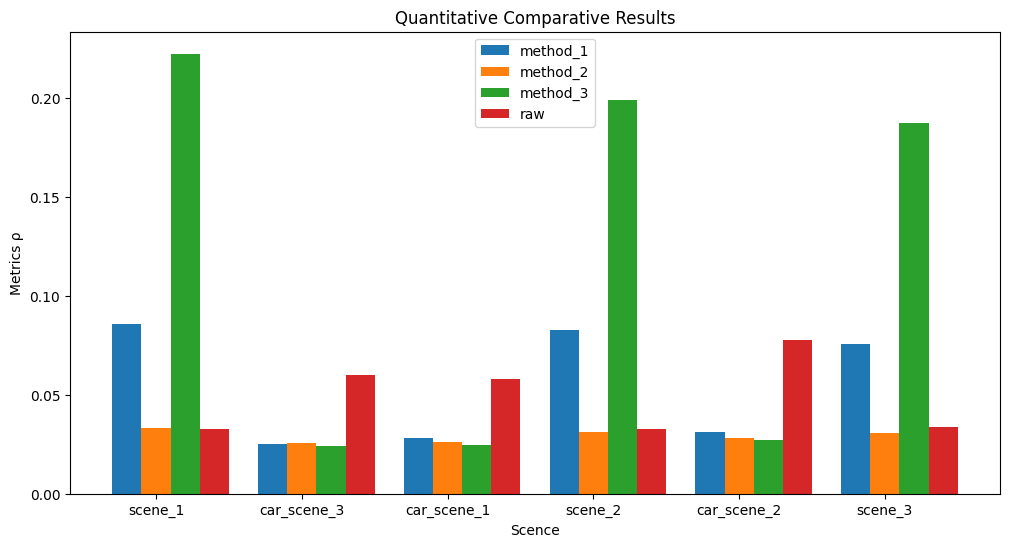

In [130]:
metric_method1 = single_metrics_loop_(data,"method_1", calculate_roughness_index, -1)
metric_method2 = single_metrics_loop_(data,"method_2", calculate_roughness_index, -1)
metric_method3 = single_metrics_loop_(data,"method_3", calculate_roughness_index, -1)
metric_raw = single_metrics_loop_(data,"raw", calculate_roughness_index, -1)
total_method = [metric_method1,metric_method2,metric_method3,metric_raw]
#=====
regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})
#=====

methods = level_one_keys
metrics = regrouped
metrics_df = pd.DataFrame(regrouped, index=methods)
metrics_df.columns = ['scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3']
#=====
n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)

# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Scence')
ax.set_ylabel('Metrics ρ')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

with auto_adjust

In [140]:
def adjust_luminosity_contrast(image: np.ndarray, alpha: float, beta: int) -> np.ndarray:
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def auto_adjust_luminosity_contrast_2(image: np.ndarray) -> np.ndarray:
    best_image = None
    best_alpha = 0.01
    best_beta = 0
    
    if len(image.shape) == 3:
        image = image[int(len(image) / 2)]
    
    alpha_range = np.arange(0.0, 2.0, 0.005)
    beta_range = np.arange(-100, 300, 5)

    # Find best alpha based on standard deviation
    best_metric = -1
    for alpha in alpha_range:
        adjusted_image = adjust_luminosity_contrast(image, alpha, 0)
        if adjusted_image is None or adjusted_image.size == 0 or np.isnan(adjusted_image).any():
            continue
        
        current_std = np.std(adjusted_image)
        
        if current_std > best_metric and 10 < current_std < 100:
            best_metric = current_std
            best_alpha = alpha
            best_image = adjusted_image
    
    if best_image is None:
        raise ValueError("No valid image was found in the first pass. Please check the input image and parameters.")
    
    # Now, find the best beta based on mean brightness
    best_metric = -1
    final_best_image = None
    for beta in beta_range:
        adjusted_image = adjust_luminosity_contrast(image, best_alpha, beta)
        if adjusted_image is None or adjusted_image.size == 0 or np.isnan(adjusted_image).any():
            continue
        
        current_mean_brightness = np.mean(adjusted_image)
        
        if current_mean_brightness > best_metric and 50 < current_mean_brightness < 200:
            best_metric = current_mean_brightness
            best_beta = beta
            final_best_image = adjusted_image
    
    if final_best_image is None:
        raise ValueError("No valid image was found in the second pass. Please check the input image and parameters.")
    
    return final_best_image, best_alpha/10, best_beta/2

In [139]:
# data_method3 = data['method_3']
# for key, val in data_method3.items():
#     for i in range(len(data_method3[key])):
#         img, alpha, beta = auto_adjust_luminosity_contrast_2(data_method3[key][i])
    

In [ ]:
# auto_adjust_luminosity_contrast_2(image: np.ndarray)

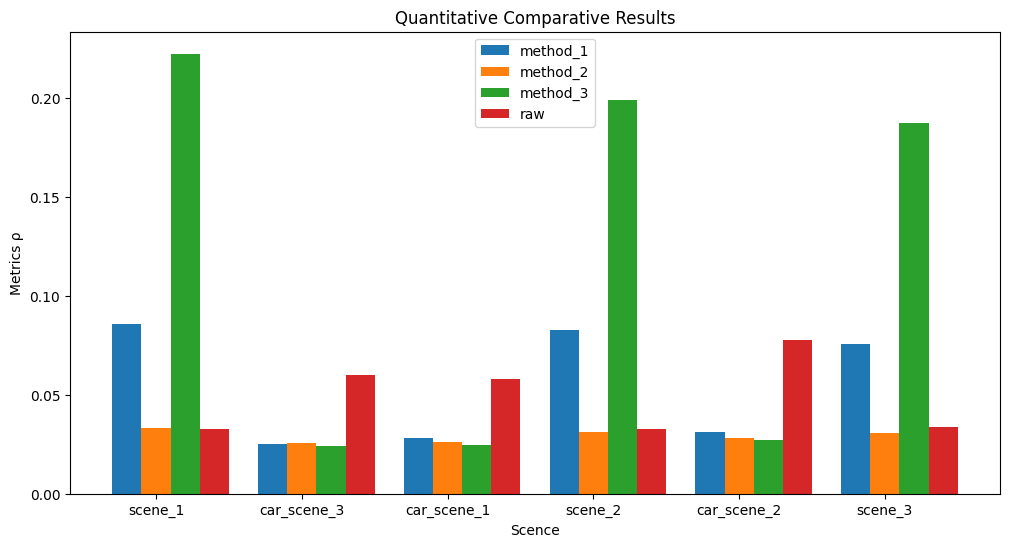

In [141]:
metric_method1 = single_metrics_loop_(data,"method_1", calculate_roughness_index, -1)
metric_method2 = single_metrics_loop_(data,"method_2", calculate_roughness_index, -1)
metric_method3 = single_metrics_loop_(data,"method_3", calculate_roughness_index, -1)
metric_raw = single_metrics_loop_(data,"raw", calculate_roughness_index, -1)
total_method = [metric_method1,metric_method2,metric_method3,metric_raw]
#=====
regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})
#=====

methods = level_one_keys
metrics = regrouped
metrics_df = pd.DataFrame(regrouped, index=methods)
metrics_df.columns = ['scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3']
#=====
n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)

# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Scence')
ax.set_ylabel('Metrics ρ')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

#### PSNR

In [76]:
def calculate_psnr_index(original_image, corrected_image):
    mse = np.mean((original_image - corrected_image) ** 2)
    max_pixel_value = 2**14 - 1  # 14-bit images
    psnr = 10 * np.log10(max_pixel_value**2 / mse)
    return psnr

In [91]:
metric_method1 = compartive_metrics_loop_(data, "method_1", calculate_psnr_index, -15)
metric_method1

{'scene_1': 105.21160652991178,
 'car_scene_3': 101.16301648880062,
 'car_scene_1': 102.7437563162556,
 'scene_2': 105.56633634892131,
 'car_scene_2': 99.87241330105783,
 'scene_3': 105.13869079402708}

C:\Users\thang\AppData\Local\Temp\ipykernel_10964\488578852.py:4: RuntimeWarning: divide by zero encountered in divide
  psnr = 10 * np.log10(max_pixel_value**2 / mse)
C:\Users\thang\AppData\Local\Temp\ipykernel_10964\488578852.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  psnr = 10 * np.log10(max_pixel_value**2 / mse)


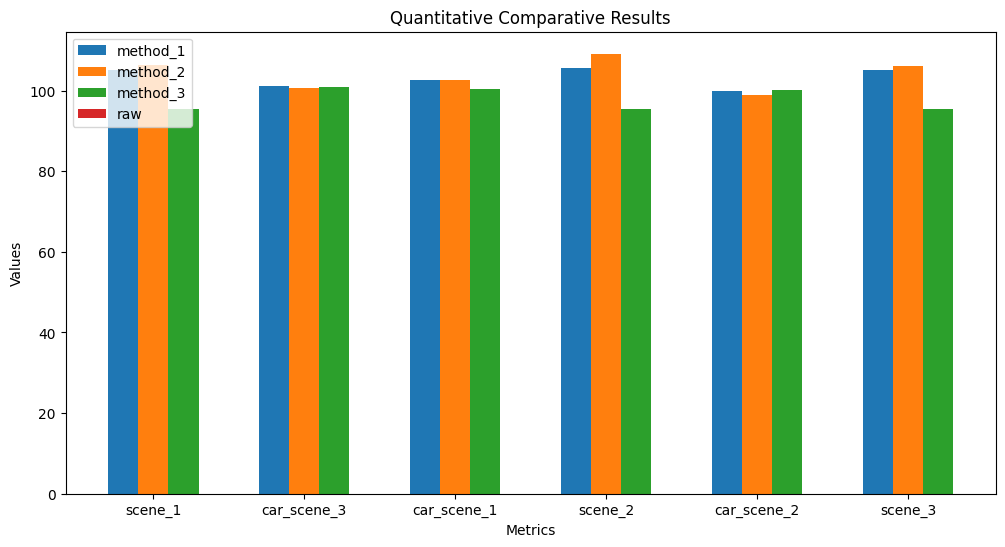

In [77]:
metric_method1 = compartive_metrics_loop_(data, "method_1", calculate_psnr_index, -15)
metric_method2 = compartive_metrics_loop_(data, "method_2", calculate_psnr_index, -15)
metric_method3 = compartive_metrics_loop_(data, "method_3", calculate_psnr_index, -15)
metric_raw = compartive_metrics_loop_(data,"raw", calculate_psnr_index, -15)

total_method = [metric_method1,metric_method2,metric_method3,metric_raw]

regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})


methods = level_one_keys
metrics = regrouped
metrics_df = pd.DataFrame(regrouped, index=methods)

n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)

# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

#### var

In [109]:
def calculate_var_index(corrected_image):
    var = np.var(corrected_image)
    return var

In [110]:
metric_method1 = single_metrics_loop_(data, "method_1", calculate_var_index, -15)
metric_method2 = single_metrics_loop_(data, "method_2", calculate_var_index, -15)
metric_method3 = single_metrics_loop_(data, "method_3", calculate_var_index, -15)
metric_raw = single_metrics_loop_(data,"raw", calculate_var_index, -15)

total_method = [metric_method1,metric_method2,metric_method3,metric_raw]

regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})


methods = level_one_keys
metrics = regrouped
label = 'scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3'
metrics_df = pd.DataFrame(regrouped, index=methods)
metrics_df.columns = ['scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3']

for i in metrics_df.columns:
    print(i)


scene_1
scene_2
scene_3
car_scene_1
car_scene_2
car_scene_3


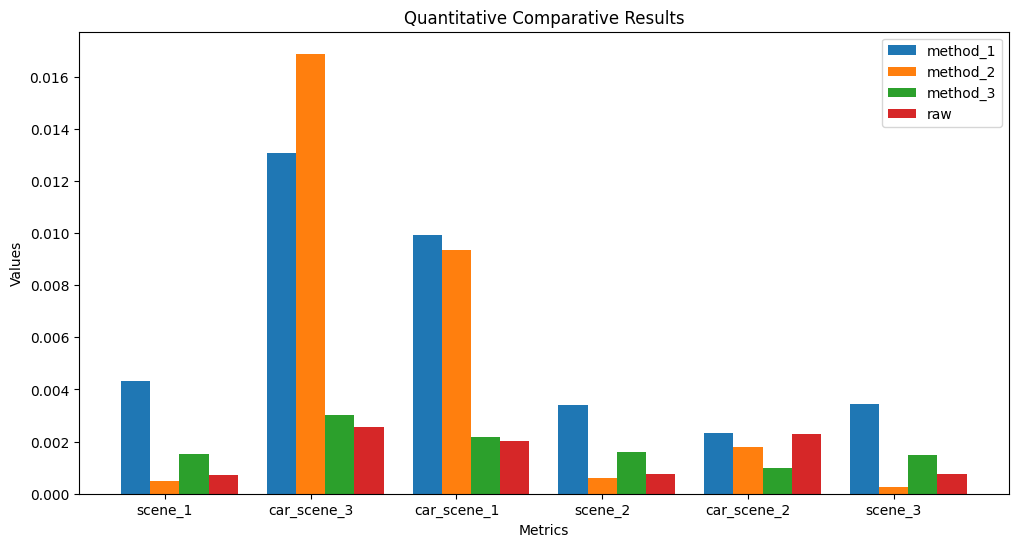

In [111]:
n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)


label = 'scene_1', 'car_scene_3', 'car_scene_1', 'scene_2', 'car_scene_2', 'scene_3'
label = 'scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3'
# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

#### NUES

In [114]:
def calculate_nues_index(corrected_image):
    mean_pixel_value = np.mean(corrected_image)
    std_deviation = np.std(corrected_image)
    nues = (std_deviation / mean_pixel_value) * 100
    
    return nues

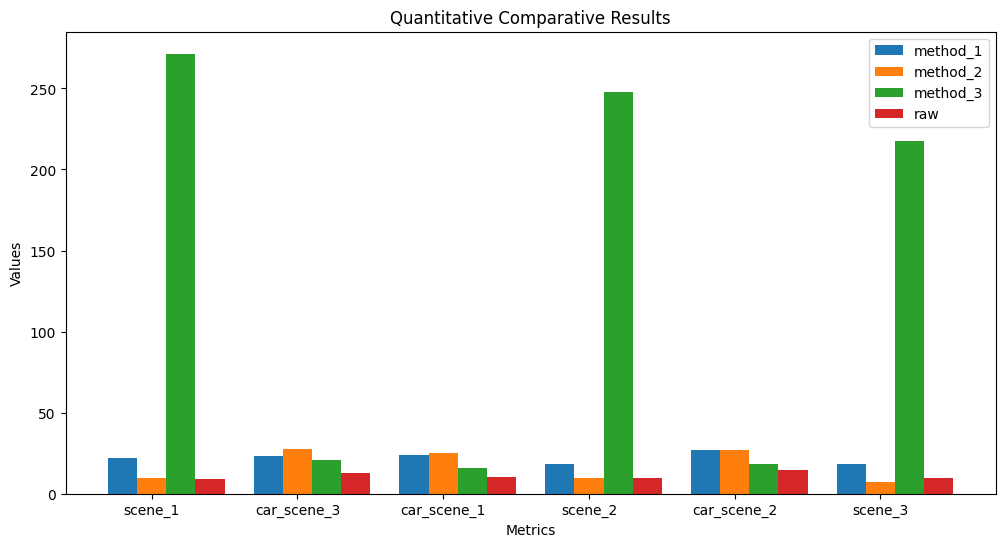

In [115]:
metric_method1 = single_metrics_loop_(data,"method_1", calculate_nues_index, -15)
metric_method2 = single_metrics_loop_(data,"method_2", calculate_nues_index, -15)
metric_method3 = single_metrics_loop_(data,"method_3", calculate_nues_index, -15)
metric_raw = single_metrics_loop_(data,"raw", calculate_nues_index, -15)
total_method = [metric_method1,metric_method2,metric_method3,metric_raw]
#=====
regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})
#=====

methods = level_one_keys
metrics = regrouped
metrics_df = pd.DataFrame(regrouped, index=methods)
metrics_df.columns = ['scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3']
#=====
n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)

# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

#### orb feature

In [124]:
def count_features(image: np.ndarray) -> int:
    if image is None or image.size == 0:
        return 0
    if len(image.shape) != 2:
        return 0
    
    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    orb = cv2.ORB_create()
    keypoints = orb.detect(image, None)
    return len(keypoints)

def feature_ratio(original_image, corrected_image):
    return count_features(corrected_image)/count_features(original_image)

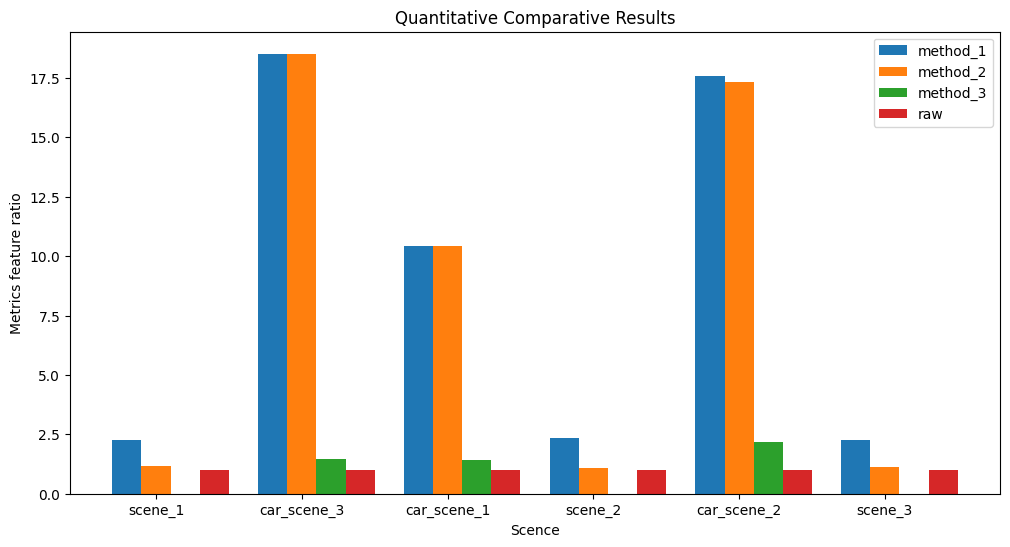

In [127]:
metric_method1 = compartive_metrics_loop_(data,"method_1", feature_ratio, -15)
metric_method2 = compartive_metrics_loop_(data,"method_2", feature_ratio, -15)
metric_method3 = compartive_metrics_loop_(data,"method_3", feature_ratio, -15)
metric_raw = compartive_metrics_loop_(data,"raw", feature_ratio, -15)
total_method = [metric_method1,metric_method2,metric_method3,metric_raw]
#=====
regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})
#=====

methods = level_one_keys
metrics = regrouped
metrics_df = pd.DataFrame(regrouped, index=methods)
metrics_df.columns = ['scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3']
#=====
n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)

# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Scence')
ax.set_ylabel('Metrics feature ratio')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

#### HOG

In [118]:
from skimage.feature import hog
from skimage import exposure

def count_features_hog(image: np.ndarray) -> int:
    if image is None or image.size == 0:
        return 0
    if len(image.shape) != 2:
        return 0

    # Convert to uint8 if not already
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Compute HOG features and HOG image
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys',
                              visualize=True, transform_sqrt=True, feature_vector=True)

    return len(features)

def feature_ratio_hog(raw, filtered):
    return count_features_hog(filtered) / count_features_hog(raw)

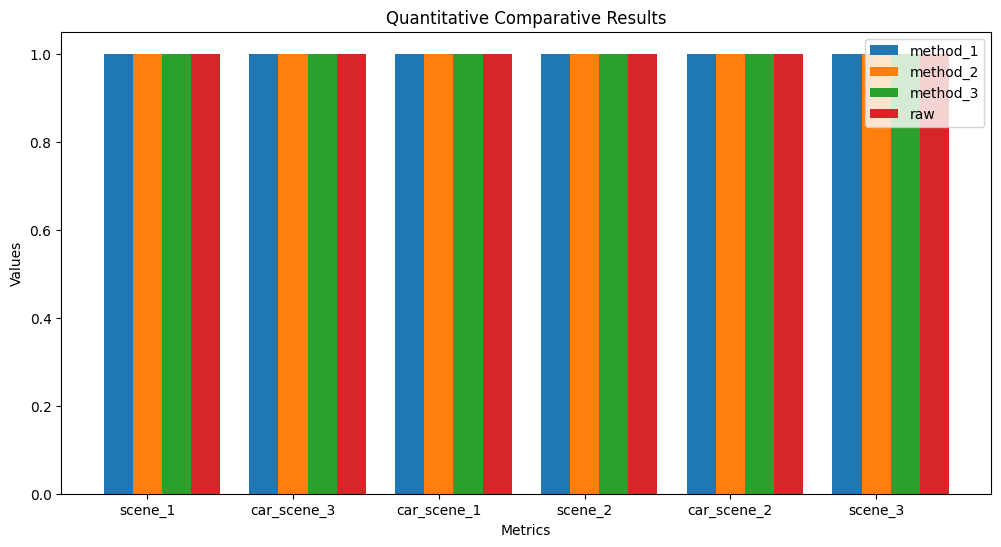

In [119]:
metric_method1 = compartive_metrics_loop_(data,"method_1", feature_ratio_hog, -15)
metric_method2 = compartive_metrics_loop_(data,"method_2", feature_ratio_hog, -15)
metric_method3 = compartive_metrics_loop_(data,"method_3", feature_ratio_hog, -15)
metric_raw = compartive_metrics_loop_(data,"raw", feature_ratio_hog, -15)
total_method = [metric_method1,metric_method2,metric_method3,metric_raw]
#=====
regrouped ={}

for key2 in level_two_keys:
    temp_val = []
    for method in total_method:
        temp_val.append(method[key2])
    regrouped.update({key2:temp_val})
#=====

methods = level_one_keys
metrics = regrouped
metrics_df = pd.DataFrame(regrouped, index=methods)
metrics_df.columns = ['scene_1', 'scene_2', 'scene_3', 'car_scene_1', 'car_scene_2', 'car_scene_3']
#=====
n_metrics = len(metrics)
n_methods = len(methods)

# Define the bar width
bar_width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))
index = np.arange(n_metrics)

# Plot each method's metrics
for i, method in enumerate(methods):
    plt.bar(index + i * bar_width, metrics_df.loc[method], bar_width, label=method)

# Add some text for labels, title and axes ticks
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Quantitative Comparative Results')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics.keys())

# Add legend
ax.legend()

# Show plot
plt.show()

# plot result

### feature metric

### other metric